In [1]:
import numpy as np
from statsmodels.tsa.stattools import ccovf
from statsmodels.tsa.stattools import ccf
from scipy.linalg import solve_continuous_lyapunov
from numba import jit
from scipy import signal
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [2]:
def threshlin(I, k):
    return k*np.maximum(I, 0)

def d_threshlin(I, k):
    return k*(np.maximum(I, 0) / np.abs(I))

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [1399]:
def theory_cov(N, k, s, r_ss, W, c_ne, c_ni, tau_n, tau):
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    L = np.diagflat(d_threshlin(s + (sgn*W)@r_ss, k))
    LW = L@(sgn*W)
    Eye = np.eye(3*N)
    
    M = (1/tau)*(-Eye + LW)
    Minv = np.linalg.inv(M)
    
    D = c_n@L
    D = (1/tau)*np.sqrt(2*tau_n)*D
    
    Sigma = Minv @ D @ ((Minv@D).T)
    
    return Sigma

In [1400]:
def model(t0, T, dt, N, tau_E, tau_I, tau_n, c_ne, c_ni, J_EE, J_II, J_EI, J_IE, k, s, a, b):
    r1 = np.zeros((N,1))
    r2 = np.zeros((N,1))
    rI = np.zeros((N,1))
    
    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((3*N, 1))
    R_n = np.zeros((3*N, 1))
    
    xs = np.linspace(0, N-1, N)

    W_E1E1 = W_E2E2 = J_EE
    W_IE1 = W_IE2 = J_IE
    W_E1I = W_E2I = J_EI
    W_II = J_II
    
    W_E1E2 = b*W_E2E2
    W_E2E1 = a*W_E1E1
    
    W = np.block([
        [W_E1E1, W_E1E2, W_E1I],
        [W_E2E1, W_E2E2, W_E2I],
        [W_IE1, W_IE2, W_II]
    ])
    
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    s = np.block([
        [s],
        [s],
        [s]
    ])
    
    r_n = np.zeros((3*N,1))
    r_ss = np.zeros((3*N,1))
    
    
    # initial inputs 
    Id = s + (sgn*W)@r_ss
    In = s + (sgn*W)@r_n
    
    
    # smoothed noise process 
    eta = np.zeros((3*N, 1))
    x1 = np.zeros((3*N,1))
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    #print(M)
    for m in range(M):
    # deterministic sim
        r_ss += (dt*(1/tau))*(-r_ss + threshlin(Id, k))
        Id = s + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        #x = np.random.randn(3*N,1)
        x1 = np.random.normal(scale=np.sqrt(dt), size=(3,1))
        #eta += (1/tau_n) * (-eta*dt + np.sqrt(2*tau_n*dt)*x) # smoothed noise
        #r_n += dt*(1/tau)*(-r_n + threshlin(In + c_n*eta,k))
        r_n += dt*(1/tau)*(-r_n + threshlin(In + c_n*x1, k))
        In = s + (sgn*W)@r_n 
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, c_ne, c_ni, tau_n
    

#### White noise

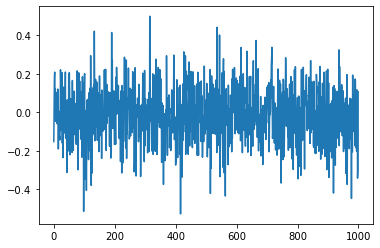

In [1427]:
T = 10
dt = 0.01
M = int(T/dt)

lst = [np.random.normal(scale=np.sqrt(2*dt)) for t in range(M)]

plt.plot(lst)
plt.show()

#### Smoothed white noise

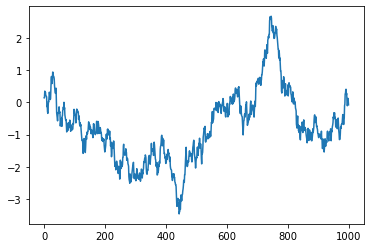

In [1402]:
T = 10
dt = 0.01
N = 1
M = int(T/dt)
ts = np.arange(M+1)
eta = 0
etas = []
#print(M)
for m in range(M):
# noise sim
    x = np.random.randn()
    eta += (1/tau_n) * (-eta*dt + np.sqrt(2*tau_n*dt)*x) # smoothed noise  
    etas.append(eta)

plt.plot(etas)
plt.show()

# Simulation

In [1403]:
r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, sigE, sigI, tau_n = model(t0=0, 
                                                     T=800, 
                                                     dt=0.01, 
                                                     N=1, 
                                                     tau_E=15, 
                                                     tau_I=15, 
                                                     tau_n=1, 
                                                     c_ne=1, 
                                                     c_ni=1, 
                                                           
                                                     J_EE=.5, 
                                                     J_II=.5, 
                                                     J_EI=.5, 
                                                     J_IE=.5,
                                                           
                                                     k = 1, 
                                                     s = 15,
                                                     a = 0.3,
                                                     b = 0.3 )

## Sample paths

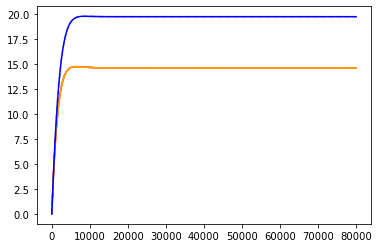

In [1404]:
plt.plot(R_n[0,:], color='red', linestyle='--', alpha=.55)
plt.plot(R_ss[0,:], color='red')

plt.plot(R_n[1,:], color='orange', linestyle='--', alpha=.55)
plt.plot(R_ss[1,:], color='orange')

plt.plot(R_n[2,:], color='b', linestyle='--', alpha=.4)
plt.plot(R_ss[2,:], color='b')

plt.show()

Clip transient:

In [1405]:
R_n = R_n[:, 20_000:]
R_ss = R_ss[:, 20_000:]

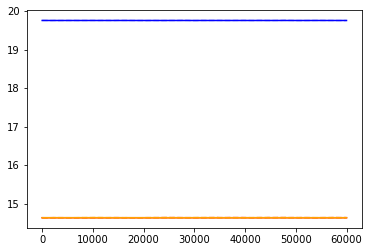

In [1406]:
plt.plot(R_n[0,:], color='red', linestyle='--', alpha=.55)
plt.plot(R_ss[0,:], color='red')

plt.plot(R_n[1,:], color='orange', linestyle='--', alpha=.55)
plt.plot(R_ss[1,:], color='orange')

plt.plot(R_n[2,:], color='b', linestyle='--', alpha=.4)
plt.plot(R_ss[2,:], color='b')

plt.show()
plt.show()
plt.show()

# Theoretical stationary cross-covariance function

Flucutations $\delta \mathbf{r}$ about the steady state rate $\overline{\mathbf{r}}$ solve the linearized equation

$$
    \delta \mathbf{\dot{r}} = M \delta \mathbf{r} + D \mathbf{x}
$$

Theoretical stationary cross-covariance function is computed:

$$ 
\tilde{C}(s) := \langle \delta \mathbf{r}_i(t), \delta \mathbf{r}_j(t+s) \rangle 
=
\begin{cases}
    \exp\left(Ms\right)\cdot \Sigma, & s > 0 \\
    \Sigma \cdot \exp\left(-M^\top s\right), & s \leq 0
\end{cases}
$$

where $\Sigma$ is the solution to the Lyapunov equation

$$
(-M)\Sigma + \Sigma (-M^\top) = DD^\top
$$

In [1407]:
def stationary_acovf(lags, M, sigma):
    nonpos_lags = lags[lags<=0]
    pos_lags = lags[lags>0]
    
    arr1 = [sigma @ expm((-M.T)*s) for s in nonpos_lags]
    arr2 = [expm(M*s) @ sigma for s in pos_lags]

    return np.append(arr1,arr2, axis=0)

In [1411]:
k=1
N=1
tau = 15
L = np.diagflat(d_threshlin(s + (sgn*W)@r_ss, k))
LW = L@(sgn*W)
Eye = np.eye(3*N)
M = (1/tau)*(-Eye + LW) # note the 1/tau

c_n = np.diagflat(np.block([
        [np.full((N,1), sigE)],
        [np.full((N,1), sigE)],
        [np.full((N,1), sigI)]
    ]))

D = c_n@L
D = (1/tau)*np.sqrt(2*tau_n)*D # note the 1/tau
#D = (1/tau)*D

sigma = solve_continuous_lyapunov(-M, D@(D.T))

In [1423]:
lags1 = np.arange(-200,200)
dt = 0.01
tau=15
acf = stationary_acovf(lags1, M, sigma)
y = [x[0,0] for x in acf]

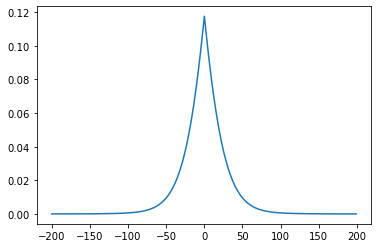

In [1424]:
plt.plot(lags1, y)
plt.show()

In [1425]:
np.trapz(y)

4.984672764558618

In [1426]:
theory_cov(N=1, k=1, s=15, r_ss=r_ss, W=W, c_ne=sigE, c_ni=sigI, tau_n=1, tau=15)

array([[4.98435349, 0.25062568, 1.09458656],
       [0.25062568, 4.98435349, 1.09458656],
       [1.09458656, 1.09458656, 1.18500892]])

In [1420]:
def xcov(x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    n = len(x)
    d = np.arange(n)
    k = np.append(d[::-1], d[1:])
    
    return signal.correlate(x-xbar, y-ybar, mode='full', method='fft')/(n-k)

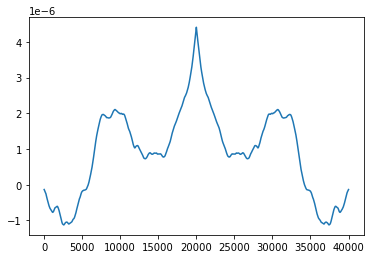

In [1421]:
plt.plot(xcov(R_n[0,:], R_n[0,:])[40_000:80_000])
plt.show()

In [1422]:
np.trapz(xcov(R_n[0,:], R_n[0,:])[40_000:80_000],dx=0.01)

0.0003696550448300506

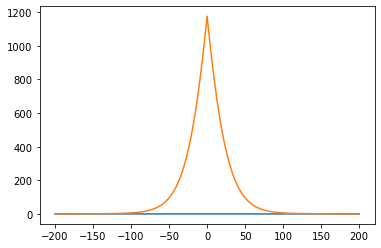

In [1355]:
lags2 = np.linspace(-200,200,40_000)
plt.plot(lags2,xcov(R_n[0,:], R_n[0,:])[40_000:80_000])
plt.plot(lags1, y)
plt.show()

In [713]:
# initial

corrmat00 = np.array([])
corrmat01 = np.array([])
corrmat02 = np.array([])
corrmat11 = np.array([])
corrmat22 = np.array([])
corrmat12 = np.array([])

r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, sigE, sigI, tau_n = model(t0=0, 
                                                    T=800, 
                                                    dt=0.01, 
                                                    N=1, 
                                                    tau_E=15, 
                                                    tau_I=15, 
                                                    tau_n=1, 
                                                    c_ne=1, 
                                                    c_ni=1, 
                                                          
                                                    J_EE=.5, 
                                                    J_II=.5, 
                                                    J_EI=.5, 
                                                    J_IE=.5,
                                                          
                                                    k = 1, 
                                                    s = 15,
                                                    a = 0.1,
                                                    b = 0.1 )
R_n = R_n[:, 20_000:]
R_ss = R_ss[:, 20_000:]  
corrmat00 = xcov(R_n[0,:], R_n[0,:])
corrmat11 = xcov(R_n[1,:], R_n[1,:])
corrmat12 = xcov(R_n[1,:], R_n[2,:])
corrmat01 = xcov(R_n[0,:], R_n[1,:])
corrmat02 = xcov(R_n[0,:], R_n[2,:])
corrmat22 = xcov(R_n[2,:], R_n[2,:])

In [721]:
# adds to existing

for sim in range(100):
    print(sim)
    r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, sigE, sigI, tau_n = model(t0=0, 
                                                     T=800, 
                                                     dt=0.01, 
                                                     N=1, 
                                                     tau_E=15, 
                                                     tau_I=15, 
                                                     tau_n=1, 
                                                     c_ne=.5, 
                                                     c_ni=.5, 

                                                     J_EE=.5, 
                                                     J_II=.5, 
                                                     J_EI=.8, 
                                                     J_IE=.25,

                                                     k = 1, 
                                                     s = 15,
                                                     a = 0.1,
                                                     b = 0.1 )
    R_n = R_n[:, 20_000:]
    R_ss = R_ss[:, 20_000:]

    corrmat00 = np.c_[corrmat00, xcov(R_n[0,:], R_n[0,:])]
    corrmat11 = np.c_[corrmat11, xcov(R_n[1,:], R_n[1,:])]
    corrmat12 = np.c_[corrmat12, xcov(R_n[1,:], R_n[2,:])]
    corrmat01 = np.c_[corrmat01, xcov(R_n[0,:], R_n[1,:])]
    corrmat02 = np.c_[corrmat02, xcov(R_n[0,:], R_n[2,:])]
    corrmat22 = np.c_[corrmat22, xcov(R_n[2,:], R_n[2,:])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [722]:
k=1
N=1
tau = 15
L = np.diagflat(d_threshlin(s + (sgn*W)@r_ss, k))
LW = L@(sgn*W)
Eye = np.eye(3*N)
M = (1/tau)*(-Eye + LW) # note the 1/tau

c_n = np.diagflat(np.block([
        [np.full((N,1), sigE)],
        [np.full((N,1), sigE)],
        [np.full((N,1), sigI)]
    ]))
D = c_n@L
D = (1/tau)*np.sqrt(2*tau_n)*D # note the 1/tau

sigma = solve_continuous_lyapunov(-M, D@(D.T))

dt = 0.01
tau=15

acf = stationary_acovf(lags1, M, sigma, dt, tau)

In [723]:
lags1 = np.arange(-200,200)
lags2 = np.linspace(-200,200,40_000)

avg00 = np.mean(corrmat00, axis=1)
avg01 = np.mean(corrmat01, axis=1)
avg02 = np.mean(corrmat02, axis=1)


y1 = [x[0,0] for x in acf]
y2 = [x[0,1] for x in acf]
y3 = [x[0,2] for x in acf]

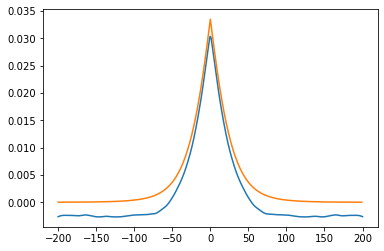

In [724]:
plt.plot(lags2, avg00[40_000:80_000])
plt.plot(lags1, y1)
plt.show()

In [725]:
theory_cov(N=1, k=1, s=15, r_ss=r_ss, W=W, c_ne=.5, c_ni=.5, tau_n=1, tau=15)

array([[ 1.59010231, -0.06279025,  0.00648999],
       [-0.06279025,  1.59010231,  0.00648999],
       [ 0.00648999,  0.00648999,  0.14169822]])

In [728]:
np.trapz(avg00[40_000:80_000], dx=0.01)

0.528663590960266

In [729]:
np.trapz(y1)

1.5897387030524772

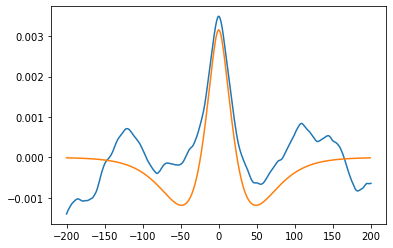

In [730]:
plt.plot(lags2, avg01[40_000:80_000])
plt.plot(lags1, y2)
plt.show()

In [731]:
np.trapz(y2)

-0.06223876273789056

In [732]:
np.trapz(2*avg01[50_000:70_000], dx=0.01)

0.17292682226820666

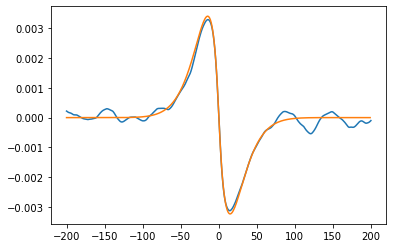

In [733]:
plt.plot(lags2, avg02[40_000:80_000])
plt.plot(lags1, y3)
plt.show()